# Investigating increasing validation loss on FF SNN
The code in this script are just copy pasted from create-dataset and inference.py

In [21]:
import torchaudio
import torch
import random
import numpy as np
import os
import pywt
import noisereduce

from snntorch import spikeplot as splt
from snntorch import spikegen

from common import SNN

import torch
import matplotlib.pyplot as plt

import numpy as np

import matplotlib.pyplot as plt

In [3]:
# input is shape time x batch x channels (from spectrogram or dwt spec)
def posneg_delta(raw_spec_data):
    delta = spikegen.delta(raw_spec_data, threshold=DM_THRESHOLD, off_spike=True)
    
    new_data = torch.zeros(delta.shape[0], delta.shape[1], delta.shape[2]*2, device=delta.device)

    pos_mask = (delta == 1)
    neg_mask = (delta == -1)

    new_data[:, :, :delta.shape[2]] = pos_mask.to(torch.float32)
    new_data[:, :, delta.shape[2]:] = neg_mask.to(torch.float32)

    return new_data

def to_spikes(paths_list, labels):
    if MODE == 'spec':
        all_spikes = []
        all_waveforms = []
        targets = np.array(labels)

        p_count = 0
        for p in paths_list:
            # log
            p_count += 1
            if p_count % 100 == 0:
                print(f'Done {p_count} samples.')
            
            samples, rate = torchaudio.load(p, normalize=True)
            
            if samples.shape[0] == 2: samples = samples[0, :]
            else: samples = samples[0]
            if(len(samples) < 24000):
                samples = torch.cat((samples, torch.tensor([0])))

            #plt.plot(np.linspace(0, len(samples), len(samples)), samples)
            
            samples = torch.tensor(noisereduce.reduce_noise(y=samples, sr=rate)) # testing this because I had it on in the ResNet version dataset

            #plt.plot(np.linspace(0, len(samples), len(samples)), samples)

            # freq bin count is nfft//2 + 1
            spec_transform = torchaudio.transforms.Spectrogram(n_fft=(2*SPEC_FREQ_BIN_COUNT-2))

            samples = samples.to(torch.float64)
            spec = spec_transform(samples)

            # convert waveform to spikes
            timesteps = spec.shape[1]
            waveform_timestep_len = (24000//timesteps) + 1

            ts_waveform = [] # timesteps but compressed to time resolution of spectrogram output
            current_t = waveform_timestep_len
            while current_t <= 24000:
                ts_waveform.append(samples[current_t-waveform_timestep_len: current_t].max())
                current_t += waveform_timestep_len

            if len(ts_waveform) < timesteps: # pad so dimensions match
                ts_waveform.append(0) 

            # normalize because amplitude scales vary a lot (and we did this in resnet accidentally)
            ts_waveform = torch.tensor(ts_waveform)
            ts_waveform = (ts_waveform - ts_waveform.min()) / (ts_waveform.max() - ts_waveform.min())

            # debug
            #plt.plot(np.linspace(0, len(samples), len(samples)), samples)
            #plt.plot(np.linspace(0, len(ts_waveform), len(ts_waveform)), ts_waveform)

            # convert compressed waveform into spikes using bins
            waveform_spikes = []
            num_bins = 20
            bin_size = 1/num_bins
            for w in ts_waveform:
                waveform_spikes.append([0 for i in range(num_bins)])
                waveform_spikes[-1][int(w//bin_size)] = 1

            waveform_spikes = torch.tensor(waveform_spikes)

            # debug
            # fig = plt.figure(facecolor="w", figsize=(10, 5))
            # ax = fig.add_subplot(111)
            # splt.raster(waveform_spikes, ax, s=5, c="black")

            all_spikes.append(spec)
            all_waveforms.append(waveform_spikes)

        # global max/min normalization
        print('Looking for global max/min...')
        global_min = 0
        global_max = 0
        for s in all_spikes:
            if s.min() < global_min: global_min = s.min()
            if s.max() > global_max: global_max = s.max()

        # now normalize everything
        print('Normalizing...')
        for i in range(len(all_spikes)):
            all_spikes[i] = (all_spikes[i]-global_min) / (global_max - global_min)

        all_spikes = torch.stack(all_spikes)
        all_waveforms = torch.stack(all_waveforms)

        # delta modulate spectrogram
        all_spikes = all_spikes.permute(2, 0, 1)
        print('Running deltamod')
        all_spikes_dm = posneg_delta(all_spikes)

        # note: here, all_spikes_dm is (timestep, batch, neuron) and all_waveforms is (batch, timestep, neuron)
        all_waveforms = all_waveforms.permute(1, 0, 2)

        return torch.cat((all_spikes_dm, all_waveforms), dim=2), torch.tensor(labels)

    # DWT MODE
    elif MODE == 'dwt':
        all_spikes = []
        all_waveforms = []
        targets = np.array(labels)

        p_count = 0
        for p in paths_list:
            # log
            p_count += 1
            if p_count % 100 == 0:
                print(f'Done {p_count} samples.')
            
            samples, rate = torchaudio.load(p, normalize=True)
            
            if samples.shape[0] == 2: samples = samples[0, :]
            else: samples = samples[0]
            if(len(samples) < 24000):
                samples = torch.cat((samples, torch.tensor([0])))

            #plt.plot(np.linspace(0, len(samples), len(samples)), samples)
            
            samples = torch.tensor(noisereduce.reduce_noise(y=samples, sr=rate)) # testing this because I had it on in the ResNet version dataset

            #plt.plot(np.linspace(0, len(samples), len(samples)), samples)

            coeffs = pywt.wavedec(samples, 'db1', level=DWT_LEVELS)

            accum = np.abs(np.array([coeffs[-1]]))
            for i in range(DWT_LEVELS - 1):
                current_coef = coeffs[DWT_LEVELS - 1 - i]
                r = np.abs(np.array([np.repeat(current_coef, pow(2, i + 1))]))
                r = r[:, 0:rate]
                accum = np.concatenate([accum, r])
            
            timestep_skip = rate//DWT_TIMESTEPS

            channels = [[] for i in range(DWT_LEVELS)]
            for i in range(rate//timestep_skip):
                for j in range(DWT_LEVELS):
                    channels[j].append(accum[j][i*timestep_skip])

            channels = torch.tensor(channels)
            channels = (channels - channels.min()) / (channels.max()-channels.min())

            # convert waveform to spikes
            timesteps = channels.shape[1]
            waveform_timestep_len = (24000//timesteps)

            ts_waveform = [] # timesteps but compressed to time resolution of spectrogram output
            current_t = waveform_timestep_len
            while current_t <= 24000:
                ts_waveform.append(samples[current_t-waveform_timestep_len: current_t].max())
                current_t += waveform_timestep_len

            if len(ts_waveform) < timesteps: # pad so dimensions match
                ts_waveform.append(0) 

            # normalize because amplitude scales vary a lot (and we did this in resnet)
            ts_waveform = torch.tensor(ts_waveform)
            ts_waveform = (ts_waveform - ts_waveform.min()) / (ts_waveform.max() - ts_waveform.min())

            # debug
            #plt.plot(np.linspace(0, len(samples), len(samples)), samples)
            #plt.plot(np.linspace(0, len(ts_waveform), len(ts_waveform)), ts_waveform)

            # convert compressed waveform into spikes using bins
            waveform_spikes = []
            num_bins = 20
            bin_size = 1/num_bins
            for w in ts_waveform:
                waveform_spikes.append([0 for i in range(num_bins)])
                waveform_spikes[-1][int(w//bin_size)] = 1

            waveform_spikes = torch.tensor(waveform_spikes)

            # debug
            # fig = plt.figure(facecolor="w", figsize=(10, 5))
            # ax = fig.add_subplot(111)
            # splt.raster(waveform_spikes, ax, s=5, c="black")

            all_spikes.append(channels)
            all_waveforms.append(waveform_spikes)

        # # global max/min normalization
        # print('Looking for global max/min...')
        # global_min = 0
        # global_max = 0
        # for s in all_spikes:
        #     if s.min() < global_min: global_min = s.min()
        #     if s.max() > global_max: global_max = s.max()

        # # now normalize everything
        # print('Normalizing...')
        # for i in range(len(all_spikes)):
        #     all_spikes[i] = (all_spikes[i]-global_min) / (global_max - global_min)

        all_spikes = torch.stack(all_spikes)
        all_waveforms = torch.stack(all_waveforms)

        # delta modulate spectrogram
        all_spikes = all_spikes.permute(2, 0, 1)
        print('Running deltamod')
        all_spikes_dm = posneg_delta(all_spikes)

        # note: here, all_spikes_dm is (timestep, batch, neuron) and all_waveforms is (batch, timestep, neuron)
        all_waveforms = all_waveforms.permute(1, 0, 2)

        return torch.cat((all_spikes_dm, all_waveforms), dim=2), torch.tensor(labels)

In [52]:
#SAMPLE_PATH = '../data/gunshotsNew/gunshot_00a19e08-79fc-41b0-9c9d-fbf2216bb47e.wav'
SAMPLE_PATH = '../data/genBackgrounds/background_000baebd-d632-4513-8fde-7720f703f411.wav'
LABEL_S = 1
MODEL_PATH = './results/16/model_best.pth'
MODE = 'dwt'
DWT_LEVELS = 7
DWT_TIMESTEPS = 500
DM_THRESHOLD = 0.05
BETA = 0.9

In [53]:
spikes, labels = to_spikes([SAMPLE_PATH], [LABEL_S])

Running deltamod


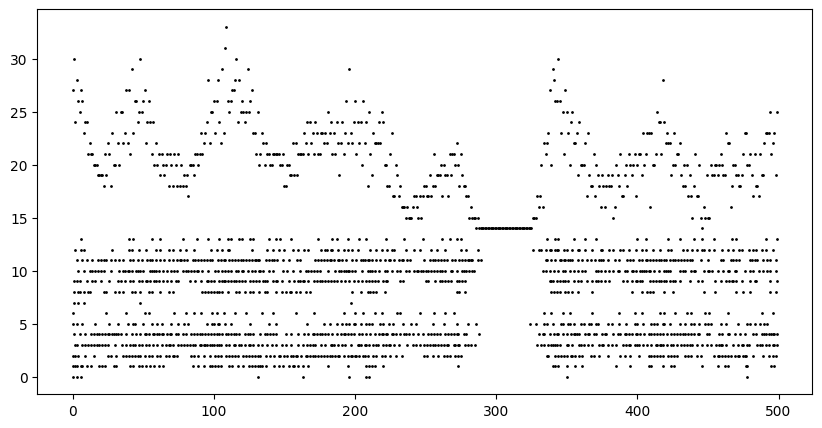

In [54]:
# visualize spikes just to be sure
fig = plt.figure(facecolor="w", figsize=(10, 5))
ax = fig.add_subplot(111)
splt.raster(spikes[:, 0, :], ax, s=1, c="black")

In [55]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

snn = SNN(spikes.shape[2], BETA, DWT_TIMESTEPS).to(device)
snn.load_state_dict(torch.load(MODEL_PATH, weights_only=True, map_location=device))
snn.eval()

spikes = spikes.to(device)

In [56]:
out = snn(spikes)
s = out[0].sum(dim=0)
print(f'{int(s[0][0])} spikes on background neuron and {int(s[0][1])} spikes on gunshot neuron')

222 spikes on background neuron and 7 spikes on gunshot neuron


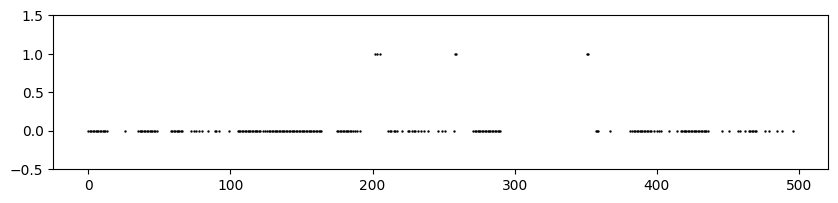

In [57]:
# let's plot spike raster for output neurons
fig = plt.figure(facecolor="w", figsize=(10, 2))
ax = fig.add_subplot(111)
plt.ylim(-0.5, 1.5)
splt.raster(out[0][:, 0, :], ax, s=0.5, c="black")